# Harrisコーナー検出
## 目的
このチュートリアルでは

* Harrisのコーナー検出の背景にある概念を理解する．
* 次の関数の使い方を学びます: [cv2.cornerHarris()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.corner#cv2.cornerHarris), [cv2.cornerSubPix()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.corner#cv2.cornerSubPix)

## 理論
前のチュートリアルで、コーナーとは、全方向に対して画素値の大きな変化が観測される領域であることを学んだ．初期のコーナー検出の試みに __Chris Harris &amp; Mike Stephens__ が 1988年に __A Combined Corner and Edge Detector__ という論文で提案した方法がある。この手法はHarrisのコーナー検出と呼ばれている．Harrisらはそのアイディアを数式で表現している．基本的にはいろいろな方向に画素の位置 (u,v) を動してみて画素値がどのように違うか（前節の「見え方の違い」）を求めるものであり、次のように表現される(噛み砕けば、shifted intensityが移動後の画素値、intensityが元の位置の画素値、その差を2乗することで0以上の値にするとともに差を強調している。その値に窓関数window functionの値を掛け、移動を全方向に行った和を求めている）:

$\displaystyle E(u,v) = \sum_{x,y} \underbrace{w(x,y)}_\text{window function} \, [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2$

ここで窓関数は矩形窓か、画素に対して重み付けをするガウシアン窓を用いる．

コーナー検出にはこの関数 $E(u,v)$ を用いる．つまり，上式の第二項を最大化するものがコーナーである．上式に対してTaylor展開を適用し、幾つかの数学処理を行うと(詳細を知りたければHarrisのコーナー検出について解説している標準的な教科書を参照のこと)，最終的に次の式が得られる:

$\displaystyle E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix}$

ここでMは以下のように定義され,

$\displaystyle M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\
                                     I_x I_y & I_y I_y \end{bmatrix}$

$I_x $と $I_y$はそれぞれ画像のx方向とy方向の勾配を表す(勾配は [cv2.Sobel()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html?highlight=cv2.sobel#cv2.Sobel) を使えば簡単に計算できる)．

そしてコーナー検出の主要部に至る．上記の処理の後，探索ウィンドウ内にコーナーを含むか否かを決定するためのスコア（基本的には式）を生成する

$\displaystyle  R = det(M) - k(trace(M))^2$

ここで
* $det(M) = \lambda_1 \lambda_2$
* $trace(M) = \lambda_1 + \lambda_2$
* $\lambda_1$ と $\lambda_2$ はMの固有値(eigen values)

つまり，これらの固有値によって対象領域がコーナー，エッジ，平坦な領域のどれかを判断する:

* $|R|$ が小さい時，すなわち$ \lambda_1$ と $\lambda_2$ の両方の値が小さい時，この領域は平坦な領域である．
* $R<0$ の時，すなわち $\lambda_1 >> \lambda_2$ もしくはその逆の時，この領域はエッジである．
* $R$ が大きい時，すなわち $\lambda_1$ と $\lambda_2$ の両方の値が大きく、 $\lambda_1 \sim \lambda_2$の時，この領域はコーナーである．

この関係を図で表すと以下:

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/harris_region.jpg)

Harrisのコーナー検出を適用した結果は、各画素が上記のスコア( R )を表すグレースケール画像になる．適切な閾値処理を施せば，画像中のコーナーを検出できる．単純な画像を使って試してみよう．

## OpenCVにおけるHarrisのコーナー検出
OpenCVは [cv2.cornerHarris(img, blockSize, ksize, k[, dst[, borderType]]))](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.cornerharris#cv2.cornerHarris) という関数を提供している．その引数は:

* `img`: 入力画像．グレースケール画像もしくはfloat32型のデータ．
* `blockSize`: コーナー検出の際に考慮する隣接領域のサイズ．
* `ksize`: Sobelの勾配オペレータのカーネルサイズ．
* `k`: Rの定義式中のパラメータ．

以下のプログラムで[使用する画像1](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_feature2d/py_features_harris/chessboard.png),
[使用する画像2](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_feature2d/py_features_harris/blox.jpg)

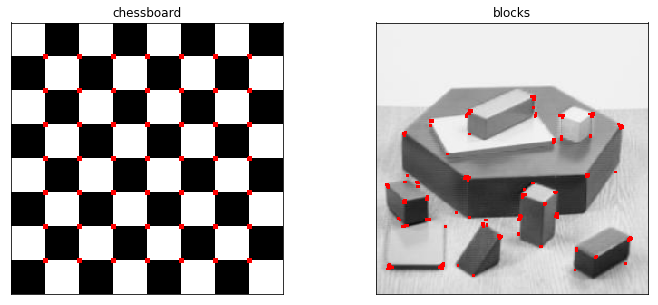

In [15]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

def harris(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img,(300,300))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)
    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()]=[0,0,255]
    return(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))

#########

img1 = harris('chessboard.png')
img2 = harris('blox.jpg')

"""
cv2.imshow('dst',img)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()
"""
plt.figure(figsize=(12,5))
plt.subplot(1,2,1),plt.imshow(img1)
plt.xticks([]),plt.yticks([]),plt.title('chessboard')
plt.subplot(1,2,2),plt.imshow(img2)
plt.xticks([]),plt.yticks([]),plt.title('blocks')

plt.show()

## サブピクセル精度のコーナー
コーナー検出の精度をできるだけ上げたいと思うかもしれない．OpenCVには [cv2.cornerSubPix(image, corners, winSize, zeroZone, criteria)](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.cornersubpix#cv2.cornerSubPix) という，検出したコーナーの精度をサブピクセル精度まで改善する関数がある．まず初めにHarrisのコーナー検出を適用する．次に，検出したコーナーの中心座標(一つのコーナーに複数の画素がある可能性があるため，その中心座標を与える)を与えて，検出精度を向上させる．Harrisコーナー検出器で検出されたコーナーを赤く，この関数により改善されたコーナーを緑色で示す．この関数を使うには、繰り返し終了条件を定義すること．例えば繰り返し計算の最大回数や達成精度などを終了条件とする．また，コーナー検出に使う隣接領域のサイズも定義する必要がある:([使用する画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_feature2d/py_features_harris/blox.jpg))

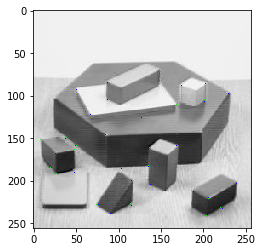

In [44]:
%matplotlib inline
import cv2
import numpy as np

filename = 'blox.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

cv2.imwrite('subpixel5.png',img)
plt.imshow(img)
plt.show()

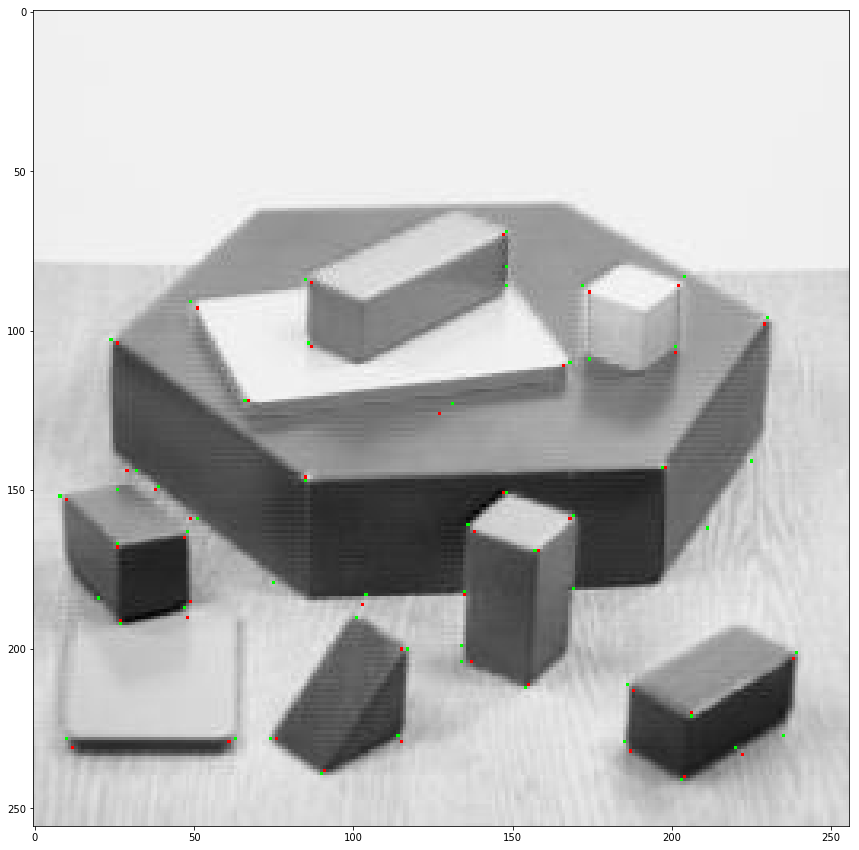

In [46]:
# 上記の拡大:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

## 補足資料
Harris, C. & Stephens, M. (1988) [A Combined Corner and Edge Detector](http://www.bmva.org/bmvc/1988/avc-88-023.pdf). In Proceedings of the 4th Alvey Vision Conference. pp. 147-151.